In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_miniodb.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_miniodbtest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 5].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 5].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,0.003067,0.009778,0.0,62623.288889,0.004166,1470.377778,11168.111111,1.0,11.0,0.975484,24.0,2.337500,1.011896e+11,5.927541
1,0.259077,0.010044,0.0,64625.777778,0.025773,1462.133333,10695.822222,1.0,26.0,0.984795,24.0,2.337500,1.011896e+11,5.927541
2,0.414789,0.009778,0.0,63624.533333,0.025773,1693.177778,11801.533333,1.0,41.0,0.959531,24.0,3.061111,1.011896e+11,5.795086
3,1.086331,0.012089,0.0,60256.711111,0.018704,1706.288889,10612.777778,1.0,57.0,0.944408,24.0,3.061111,1.011896e+11,5.795086
4,1.505856,0.011911,0.0,60256.711111,0.018704,1940.933333,11811.822222,1.0,61.0,0.955360,24.0,4.214100,1.011896e+11,5.769857


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
460,0.413613,497.947238,0.962448,11.0
461,0.413613,497.947238,0.952769,26.0
462,0.450463,499.714253,0.974892,42.0
463,0.450463,499.714253,0.951142,57.0
464,0.632927,499.421798,0.986462,61.0


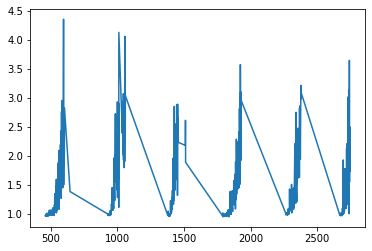

In [6]:
plt.plot(df_t['responsetime'])

In [7]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
2740,3.096766,586.417766,1.808856,606.0
2741,3.089141,582.841344,3.649269,606.0
2742,3.089141,582.841344,1.720043,604.0
2743,3.106525,582.632448,2.502394,606.0
2744,3.106525,582.632448,1.555946,608.0


In [8]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [9]:
df_t.shape

(667, 4)

In [10]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

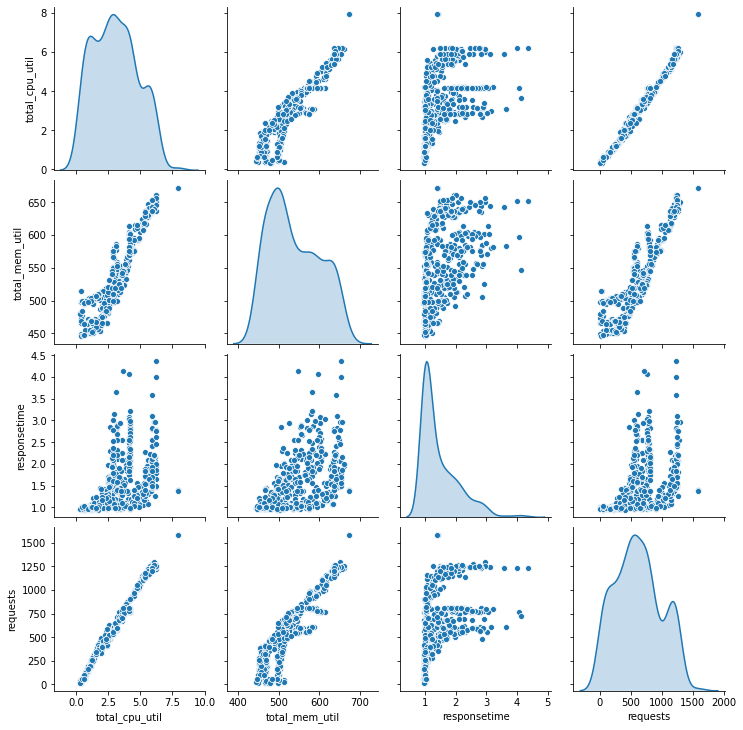

In [11]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,534.0,3.066378,1.708932,0.320483,1.581870,2.967095,4.169659,7.939723
total_mem_util,534.0,539.073233,61.621459,445.255070,491.830886,523.818981,591.755356,672.068198
responsetime,534.0,1.469717,0.612843,0.942699,1.001953,1.198480,1.802157,4.360729
requests,534.0,622.237828,364.983581,10.000000,343.000000,592.500000,820.500000,1586.000000


In [13]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [14]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
2368,4.186607,585.440827,2.313604,809.0
1433,2.807295,518.857097,1.410276,533.0
474,0.996737,503.174554,0.982432,165.0
2330,3.756690,529.188826,1.660606,747.0
536,4.645402,592.766362,1.063196,1001.0


In [15]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [16]:
train_labels.head()

2368     809.0
1433     533.0
474      165.0
2330     747.0
536     1001.0
Name: requests, dtype: float64

In [17]:
normalizer = preprocessing.Normalization()

In [18]:
normalizer.adapt(np.array(train_features))

In [19]:
print(normalizer.mean.numpy())

[  3.066 539.073   1.47 ]


## Linear Regression

In [20]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [21]:
model = tf.keras.Sequential([
    input_normalizer,
    layers.Dense(units=1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


In [22]:
model.predict(test_features)

array([[-0.893],
       [-0.895],
       [-0.914],
       [-0.874],
       [-0.87 ],
       [-0.849],
       [-0.834],
       [-0.839],
       [-0.84 ],
       [-0.849],
       [-0.851],
       [-0.799],
       [-0.503],
       [-0.452],
       [-0.449],
       [-0.455],
       [-0.457],
       [-0.348],
       [-0.375],
       [-0.363],
       [-0.365],
       [-0.181],
       [-0.211],
       [-0.223],
       [-0.225],
       [-0.204],
       [-0.204],
       [-0.136],
       [-0.164],
       [-0.155],
       [-0.14 ],
       [-0.099],
       [-0.102],
       [-0.054],
       [-0.033],
       [-0.03 ],
       [ 0.003],
       [ 0.101],
       [ 0.082],
       [ 0.127],
       [ 0.135],
       [ 0.141],
       [ 0.13 ],
       [ 0.124],
       [ 0.148],
       [ 0.182],
       [ 0.181],
       [ 0.215],
       [ 0.228],
       [ 0.281],
       [ 0.283],
       [ 0.329],
       [ 0.319],
       [ 0.33 ],
       [ 0.356],
       [ 0.357],
       [ 0.347],
       [ 0.54 ],
       [ 0.465

In [23]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [24]:
%%time
history = model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 26.6 s, sys: 3.54 s, total: 30.1 s
Wall time: 21.4 s


In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
995,26.232265,24.550920,995
996,26.229115,24.561062,996
997,26.237164,24.572716,997
998,26.230639,24.572304,998
999,26.227541,24.560356,999


In [26]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 500])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

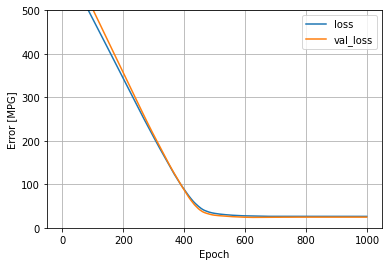

In [27]:
plot_loss(history)

In [28]:
test_results = {}

test_results['model'] = model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']],
    val_labels, verbose=0)

In [29]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [30]:
dnn_model = build_and_compile_model(input_normalizer)

In [31]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [32]:
%%time
history = dnn_model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 38 s, sys: 5.29 s, total: 43.3 s
Wall time: 29 s


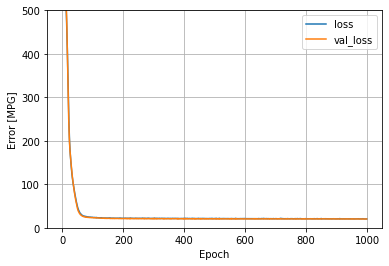

In [33]:
plot_loss(history)

In [34]:
test_results['dnn_model'] = dnn_model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']], val_labels,
    verbose=0)

In [35]:
pd.DataFrame(test_results, index=['requests']).T

,requests
model,26.154303
dnn_model,21.888004


## Make Predictions

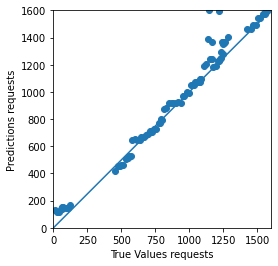

In [36]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values requests')
plt.ylabel('Predictions requests')
lims = [0, 1600]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [37]:
from sklearn.metrics import r2_score
R = r2_score(test_labels, test_predictions)
print ('R² :',R)

R² : 0.9493989428952948


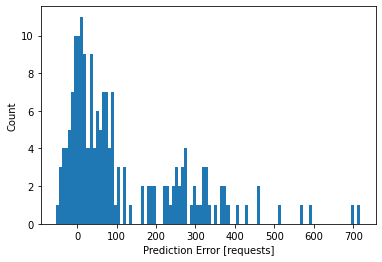

In [38]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')